In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from rest.utils import *

import numpy as np
import casadi as ca


#### **Lead-in for Mountain Car Example**

The mountain car problem is a classical control challenge that illustrates the dynamics of a car moving on a slope. This problem is influenced by gravity, the slope's inclination, and an applied acceleration input, as depicted in Figure following. The primary objective is to design a controller using various methods (e.g. LQR, MPC, RL) to drive the car from an initial state $x_0$ to a predefined terminal state $x_T$, adhering to constraints throughout the process. In the first chapter, we will introduce how to implememnt a Dynamical Progamming based controller to achieve this goal. This start with implementing the mountain car environment (define the slope and variable constraints), followed by system dynamics and controller based on Dynamic Programming.

![Figure 1: Illustration of a mountain car problem](/home/haocheng/core_course_examples/figure/MountainCarIllustration.png)

*Note that: in this chapter, we implement the **Approximate** Dynamic Programming (ADP). This approach builds upon traditional dynamic programming by discretizing the state space into a grid. The policy and cost-to-go values are computed on this grid, and two-dimensional interpolation is employed to extend these values to the whole continuous state space, providing a continuous representation of the policy and cost-to-go function.*

----

#### **Part (a): define the mountain car environment**


In this part, we aim to set up the environment for the mountain car problem. The environment consists of defining the terrain profile, mapping the terrain to inclination angles, and specifying task parameters for the controller. The steps include creating a mathematical representation of the terrain, deriving the relationship between the slope and inclination angle, and finally specifying parameters such as the initial state, terminal state, and constraints to uniquely define a control task.


**Step 1: define function that describing the mountain profile $h(p)$ (height $h$ with reference to horizontal position $p$)**

 - case 1: zero slope (linear case): $\quad h(p) = c, p \in [\underline{p}, \overline{p}]$

 - case 2: constant slope (linear case): $\quad h(p) = k \cdot p, p \in [\underline{p}, \overline{p}]$

**Note:** To simplify the problem, we will use these preliminary cases as examples. In real-world applications, the slope may often be non-linear (e.g., described by trigonometric or power functions). Such non-linear profiles can result in a more complex dynamic system, making the solution significantly more challenging.

In [2]:
# Define the profile of mountain h(p)
#  - argument: 1) p: CasAdi symbolic expression `p`
#              2) case: integer value to choose the profile of mountain
#  - return: value of `h`

def h(p, case):

    if case == 1:  # zero slope
        h = 0

    elif case == 2: # constant slope
        k = ca.pi / 18
        h = k * p

    return h


**Step 2: define the mapping from profile $h(p)$ to inclination angle $\theta(p)$**

- Transformation function from $h$ to $\theta$:

   \begin{align*}
     \theta = arctan(\frac{dh}{dp})
   \end{align*}

- Hint: 

  1. with using the CasAdi symbolic expression as the input, we can directly solve the gradient $\frac{dh}{dp}$ with method `ca.jacobian(h, p)`; 

  2. $\theta$ defined in radius;  

- Notice: If the function $h(p)$ is defined numerically rather than symbolically, we can also use **numerical differentiation** to calculate $\frac{dh}{dp}$.

In [3]:
# Calculate inclination angle theta(p) based on terrain profile h(p)
#  - argument: CasAdi symbolic expression `h_func`
#  - return: CasAdi symbolic expression `theta(p)`

def symbolic_theta(h_func):

    p = ca.SX.sym("p")

    h = h_func(p) 
    dh_dp = ca.jacobian(h, p)
    theta = ca.atan(dh_dp)
    
    return ca.Function("theta", [p], [theta])


**Step 3: specify the parameters in environments to uniquely define a task for controller**

- Task: start from given initial position $p_0$, to reach a given target position $p_T$ (Stabilization)

- At last, you can use the pre-defined method `test_env()` to check the slope $h(p)$ and curve of inclination angle $\theta(p)$ as defined in step 2.



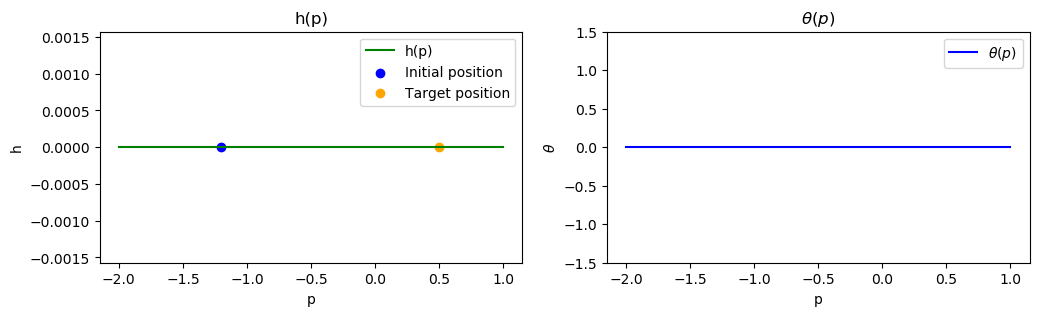

In [4]:
case = 1 # 1, 2

# Define the initial / target state
initial_position = -1.2
initial_velocity = 0.0
target_position = 0.5
target_velocity = 0.0

# Define the state / input constraints
state_lbs = np.array([-2.0, -1.0])
state_ubs = np.array([1.0, 1.0])
input_lbs = -0.10
input_ubs = 0.25

# Instantiate class 'Env'
#  - argument: 1) `case`: n in [1, 2], type: int
#              2) `initial state`: x_0 = [p_0, v_0] ^ T, type: np.array
#              3) `terminal state`: x_T = [p_T, v_T] ^ T, type: np.array
#              4) `h`: mountain profile w.r.t. cases (defined in step 1), type: function
#              5) `symbolic_theta`: CasAdi symbolic expression of inclination angle (defined in step 2), type: ca.Function
#              6) constraints on states and inputs:
#                  - `lbx`: lower limit of state, type: np.array or None (if no related limit)
#                  - `ubx`: upper limit of state, type: np.array or None (if no related limit)
#                  - `lbu`: lower limit of input, type: np.array or None (if no related limit)
#                  - `ubu`: upper limit of input, type: float or None (if no related limit)

env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]), h, symbolic_theta, 
          state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)

# Results visualisation
env.test_env() #  shape of slope (left side) and theta curve (right side) 

----

#### **Part (b): define the system dynamics**

In the previous section, we defined the mountain car environment, including the terrain profile and the mapping from the profile to the inclination angle. In this section, we will define class that describing the system dynamics of the mountain car. This includes specifying the state and input vectors, constructing the dynamics equations using symbolic computation in CasADi, and setting up the dynamics class.


- Notation: 
   - $p$: position in horizontal direction
   - $v$: velocity in horizontal direction
   - $a$: acceleration in body frame (tangent to the slope)

- System dynmaics (in State space representation): 
   - state vector $\boldsymbol{x} = [p, v]^T$
   - input vector $u = a$
   - system dynamics:
   \begin{align*}
     \begin{bmatrix} \dot{p} \\ \dot{v} \end{bmatrix} = \begin{bmatrix} v \\ - g \sin(\theta) \cos(\theta) \end{bmatrix} + \begin{bmatrix} 0 \\ \cos(\theta)  \end{bmatrix} a
   \end{align*}


**Step 1: define the setup function for mountain car dynamics**

- Hints about defining CasADi symbolic expression: 

  1. The variables used for symbolic computation should be declared in datatype `ca.SX` or `ca.MX`;

  2. To package up several variables into a vector, use `ca.vertcat(a, b, ...)`;

  3. To define a CasADi funciton, use `ca.Function("function_name", [input1, input2, ...], [output])`;
  
  4. To call a CasADi funciton, use `function_name(input1, input2, ...))`;

- Supplementary materials:
  
  Introduction to symbolic system in CasADi: https://web.casadi.org/docs/#document-symbolic
  
  API for Python in CasADi: https://web.casadi.org/python-api/
  

In [5]:
# Step2: define dynamics of 1d mountain car
#  - arguments: `theta_function`: CasADi symbolic function of inclination angle `theta_function`, type: ca.Function
#  - return: `dynamics_function`: CasADi symbolic function of dynamics, type: ca.Function

def setup_dynamics(theta_function):

    p = ca.SX.sym("p")
    v = ca.SX.sym("v")
    a = ca.SX.sym("a")
    Gravity = 9.81

    theta = theta_function(p)

    # Expression of dynamics
    dpdt = v
    dvdt = a * ca.cos(theta) #- Gravity * ca.sin(theta) * ca.cos(theta)
    
    state = ca.vertcat(p, v)
    input = ca.vertcat(a)
    rhs = ca.vertcat(dpdt, dvdt)

    return ca.Function("dynamics_function", [state, input], [rhs])


**Step 2: specify the arguments for class 'Dynmaics' and instantiate the class**
  
- Notice: symbolic_dynamics depends on the method from external object (theta), therefore, external object 'env' must entry the constructor;

In [6]:
# Define the states and input as symbolic variables
state_names = ["p", "v"]
input_names = ["a"]

# Instantiate class 'Dynamics'
#  - arguments: 1) `env`: object of class `Env`, type: Env
#              2) `state_names`: names of state variables, type: list[str]
#              3) `input_names`: names of input variables, type: list[str]
#              4) `setup_dynamics`: setup function for system dynamics defined in the last step, type: function

dynamics = Dynamics(env, state_names, input_names, setup_dynamics)


----

#### **Part (C): Implement the Dynamic Programming-based Controller**

Problem formulation (expressed in way of OCP):

$$
J_k(\boldsymbol{x_k}) = \min_{u_{k|k}, \ldots, u_{k+N-1|k}} 
\sum_{i=0}^{N} \left[ \left( \boldsymbol{x_{k+i|k}} - \boldsymbol{x_T} \right)^T \boldsymbol{Q} \left( \boldsymbol{x_{k+i|k}} - \boldsymbol{x_T} \right) + u_{k+i|k} ^T \boldsymbol{R} u_{k+i|k} \right]
+ \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)^T \boldsymbol{Q_f} \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)
$$

**subject to:**

$$
\boldsymbol{x_{k+i+1|k}} = \boldsymbol{A_{d}} \boldsymbol{x_{k+i|k}} + \boldsymbol{B_{d}}u_{k+i|k}, \quad \forall i \in \{0, \ldots, N-1\}
$$

$$
\boldsymbol{x_{k+i|k}} \in \mathcal{X}, \quad \forall i \in \{0, \ldots, N\}
$$

$$
u_{k+i|k} \in \mathcal{U}, \quad \forall i \in \{0, \ldots, N-1\}
$$

$$
\boldsymbol{x_{1,k|k}} = \boldsymbol{x_{1,k}}, \quad \boldsymbol{x_{2,k|k}} = \boldsymbol{x_{2,k}}
$$

**Step 1: define stage cost and terminal cost**  

Define the function of stage cost $l(\boldsymbol{x}, u)$ and terminal cost $g(\boldsymbol{x})$, which will be called in the following DP algorithm.

In [7]:
def terminal_cost_external(self, x):
    return x.T @ self.Qf @ x


def stage_cost_external(self, x, u):
    return x.T @ self.Q @ x + self.R * u**2


**Step 2: define the auxiliary formula to connect the cost for next state with the cost for current state**  

Besides of the stage cost and terminal cost, we notice that at each time step the DP algorithm is calculated in a recursion manner, in which we treat the current cost $l_k(\boldsymbol{x}_k, u_k)$ and the cost-to-go $J_{k+1}(\boldsymbol{x}_{k+1})$ in a whole and optimatize the current input $u_k$ over them. Therefore it's necessary to define an auxiliary formula, which combines:

* the current cost $l_k(\boldsymbol{x}_k, u_k)$: get from function 'stage_cost' through giving current state $\boldsymbol{x}_k$ and input $u_k$;
* the cost-to-go $J_{k+1}(\boldsymbol{x}_{k+1})$: get from the cost-to-go function 'J_func' through giving the next state $\boldsymbol{x}_{k+1}$

*Note that:*
1) *formula for one-step-prediction will be needed, by assuming a linear time-invariant dynamcis (LTI) it can be calculated with $\boldsymbol{A}_d$ and $\boldsymbol{B}_d$;*
2) *next state derived from ne-step-prediction may not be on the grid mesh, therefore a interpolation function for cost-to-go over mesh grid is necessary, here we assume this interpolation function is `J_func`, the definition will be given in the code box following;*

In [8]:
def recursion_cost_external(self, u, x):
    
    # Calculate the next state based on the current state and input
    x_next = self.Ad @ x + self.Bd.flatten() * u

    # Use linear interpolation to find the value of J at the next state
    J_next = self.J_func(x_next[0], x_next[1])

    return self.stage_cost(x, u) + J_next

**Step 3: define DP algorithm based on given formulas and cost functions**  

Implement the `setup_external()` function as part of the `DPController` class. This function performs the following tasks:

1) **Generate a discretized grid mesh for the state space**  

   Use `numpy.linspace` to generate a grid, based on the state bounds and target state values.

2) **Initialize the policy (`self.U`) and cost-to-go (`self.J`) matrices as zero matrices**  

   These matrices will be updated during the computation of the optimal policy and cost-to-go.

3) **Initialize the cost matrix with terminal costs**  

   Evaluate the `terminal_cost` function at each grid point to calculate the terminal costs for each state.

4) **Iteratively solve the Bellman recursion**  

   Use the Bellman recursion to compute the optimal policy and cost-to-go for each state in the discretized grid.

5) **Update the interpolated functions (`self.U_func` and `self.J_func`)**  

   At each step, use `scipy.interp2d` to create interpolated functions for the optimal policy (`self.U_func`) and the cost-to-go (`self.J_func`).

In [9]:
def setup_external(self) -> None:
    
    # Generate grid mesh for state space
    self.X1 = np.linspace(self.env.state_lbs[0]-self.target_state[0], self.env.state_ubs[0]-self.target_state[0], self.num_x1)
    self.X2 = np.linspace(self.env.state_lbs[1]-self.target_state[1], self.env.state_ubs[1]-self.target_state[1], self.num_x2)
    
    # Initialize policy and cost-to-go function, and generate interpolation over grid mesh
    self.U = np.zeros((self.num_x1, self.num_x2))
    self.U_func = interp2d(self.X1, self.X2, self.U.T, kind='linear')

    self.J = np.zeros((self.num_x1, self.num_x2))

    for i in range(self.num_x1): # initialize cost matirx with terminal cost
        for j in range(self.num_x2):
            self.J[i, j] = self.terminal_cost(np.array([self.X1[i], self.X2[j]]))

    self.J_func = interp2d(self.X1, self.X2, self.J.T, kind='linear')
    
    # Iterate over time steps from backward to forward
    for n in range(self.N, 0, -1):
        J_temp = np.zeros((self.num_x1, self.num_x2))

        for i in range(self.num_x1):
            for j in range(self.num_x2):

                # Extract current state
                x_current = np.array([self.X1[i], self.X2[j]])

                # Solve for optimal control input
                res = minimize(
                    self.recursion_cost,
                    x0=0,
                    args=(x_current, ),
                    bounds=[(self.env.input_lbs, self.env.input_ubs)],
                    method='SLSQP'
                )
                
                # Extract optimal policy and cost-to-go 
                self.U[i, j] = res.x
                J_temp[i, j] = res.fun

        self.J = J_temp

        # Re-interpolation over grid mesh after each iteration
        self.J_func = interp2d(self.X1, self.X2, self.J.T, kind='linear')
        self.U_func = interp2d(self.X1, self.X2, self.U.T, kind='linear')
    

**Step 4: bind the defined cost functions and DP algorithm to the class `DPController`**  

- Steps: 

  1) Bind the defined setup function for DP algorithm `setup_external()` to class `DPController`, it will be automatically called by constructor;

  2) Specify the arguments and instantiate the class `DPController`; 

  3) call function `plot_policy_and_cost()` to visualize the heatmap of policy and cost-to-go over states;
  


/tmp/ipykernel_21218/1145818074.py:9: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  self.U_func = interp2d(self.X1, self.X2, self.U.T, kind='linear')
/tmp/ipykernel_21218/1145818074.py:17: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` i

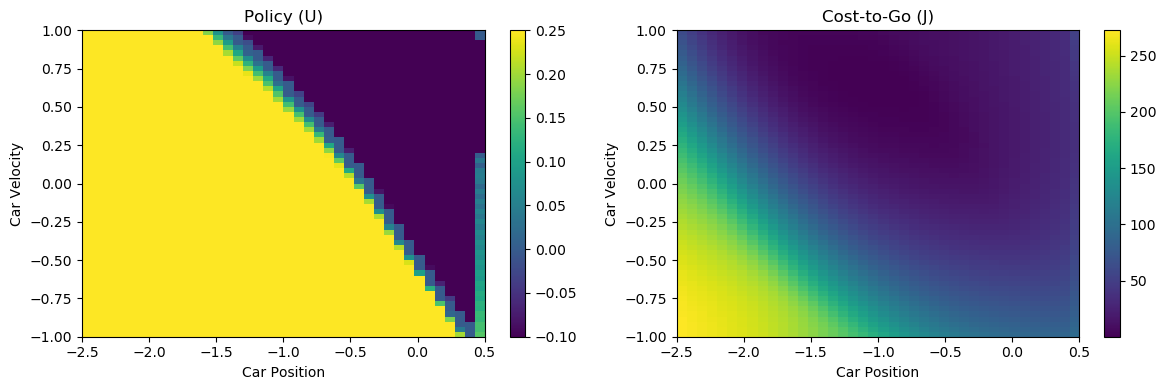

In [10]:
# Bind the defined DP algorithm to the corresponding class, will be automatically called by constructor
DPController.terminal_cost = terminal_cost_external
DPController.stage_cost = stage_cost_external
DPController.recursion_cost = recursion_cost_external
DPController.setup = setup_external

# Define control frequency of controller and time length of simulation
freq = 10
horizon = 40 # horizon length: 4s

# Define weight matrix in stage and terminal cost
Q = np.diag([1, 1])
R = np.array([[1]])
Qf = Q

# Instantiate the DP controller class
#  - arguments: 1) `env`: object of class `Env`, type
#               2) `dynamics`: object of class `Dynamics`,
#               3) weight matrices in cost functions:
#                   - `Q`: weight metrix for current state $x_k$ in stage cost $J_s$, type: np.array
#                   - `R`: weight metrix for current input $u_k$ in stage cost $J_s$, type: np.array
#                   - `Q_f`: weight metrix for terminal state $x_N$ in terminal cost $J_f$, type: np.array
#               4) `freq`: control frequency $f$ , type: int
#               5) `horizon`: number of discretized time intervals (i.e. shooting nodes - 1) $N = t_f \times f$, type: int

controller_dp = DPController(env, dynamics, Q, R, Qf, freq, Horizon=horizon)
controller_dp.plot_policy_and_cost()


**Step 4: run the simulation to see the performance of controller**  

- Steps: 

  1) Instantiate the class `Simulator` and run function `run_simulation()` to generate the simulated state- and input-trajectory;

  2) Instantiate the class `Visualizor`, run function `display_final_results()` and `display_animation()` to show the simulations;
  

Simulation finished, will start plotting


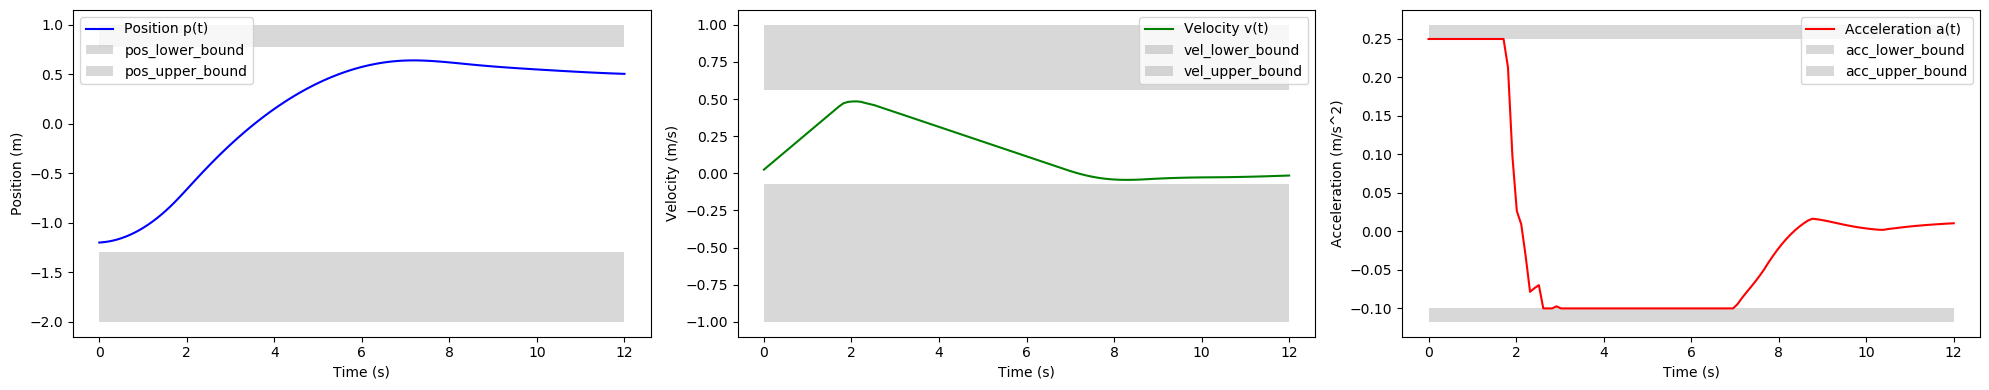

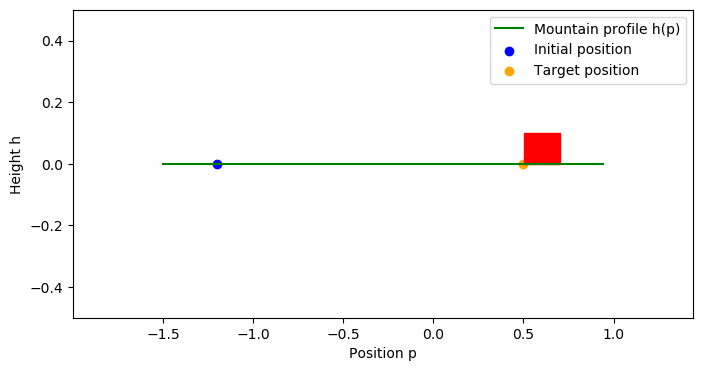

In [11]:
# Define time length of simulation
# Note: should be longer than horizon to reach a steady state
t_terminal = 12

# Instantiate the simulator, and then run the simulation
simulator_dp = Simulator(dynamics, controller_dp, env, 1/freq, t_terminal)
simulator_dp.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_dp = Visualizer(simulator_dp)
visualizer_dp.display_plots()
visualizer_dp.display_animation()


----

#### **Part (d): Section review and specify your own task**

The procedure of uniquely defining a control task and specifing a controller to solve the task is shown as following. Based on this pipeline, you can also change several parameter (e.g. slope curve, initial state and target state) to create your own task and observe how it impact the controller's performance. Now it's time to play around it, have fun with your first controller implementation!

/tmp/ipykernel_21218/1145818074.py:9: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  self.U_func = interp2d(self.X1, self.X2, self.U.T, kind='linear')
/tmp/ipykernel_21218/1145818074.py:17: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` i

Simulation finished, will start plotting


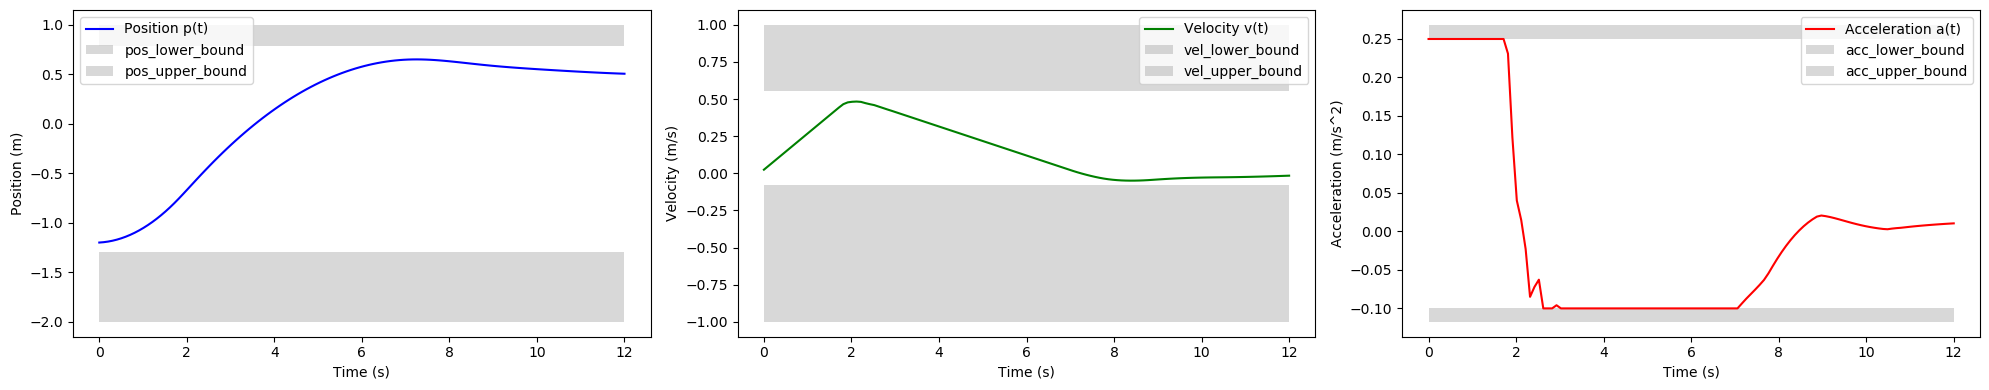

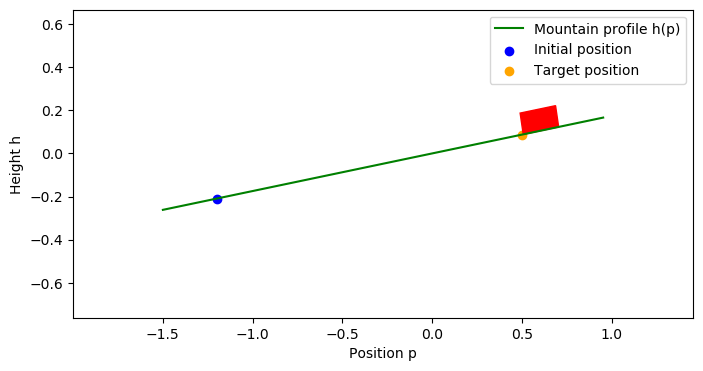

In [12]:
case_2 = 2 # 1, 2

# Define the initial / target state
initial_state_2 = np.array([-1.2, 0.0])
target_state_2 = np.array([0.5, 0.0])

# Define the state / input constraints
state_lbs_2 = np.array([-2.0, -1.0])
state_ubs_2 = np.array([1.0, 1.0])
input_lbs_2 = -0.10
input_ubs_2 = 0.25

# Instantiate class 'Env'
env_2 = Env(case_2, initial_state_2, target_state_2, h, symbolic_theta, 
          state_lbs=state_lbs_2, state_ubs=state_ubs_2, input_lbs=input_lbs_2, input_ubs=input_ubs_2)

# Instantiate class 'Dynamics'
dynamics_2 = Dynamics(env_2, state_names, input_names, setup_dynamics)

# Define control frequency of controller and time length of simulation
freq_2 = 10
horizon_2 = 40 # horizon length: 4s

# Define weight matrix in stage and terminal cost
Q_2 = np.diag([1, 1])
R_2 = np.array([[1]])
Qf_2 = Q_2

# Instantiate the DP controller class
controller_dp_2 = DPController(env_2, dynamics_2, Q_2, R_2, Qf_2, freq_2, Horizon=horizon_2)

# Define time length of simulation
# Note: should be longer than horizon to reach a steady state
t_terminal_2 = 12

# Instantiate the simulator, and then run the simulation
simulator_dp_2 = Simulator(dynamics_2, controller_dp_2, env_2, 1/freq_2, t_terminal_2)
simulator_dp_2.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_dp_2 = Visualizer(simulator_dp_2)
visualizer_dp_2.display_plots()
visualizer_dp_2.display_animation()